# Generador de Haikus 1.0
En este Notebook se explicará el primer acercamiento a la creación de un generador de haikus realizado con Deep Learning. En primer lugar, es necesario destacar que este experimento ha sido llevado a cabo usando referencias de generación de textos en prosa.

Se llevará a cabo un modelo de red neuronal recurrente haciendo uso de una capa LSTM para la generación de haikus a nivel de caracter.

A continuación podemos ver todos los módulos que serán usados en el presente código.

In [2]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import LambdaCallback
from keras.models import Sequential
from keras.layers import Dense, Activation, LSTM
from keras.optimizers import RMSprop
import pandas as pd
import csv
import numpy as np
import string as string
import random
import sys

## 1. Configuración del Notebook
En este bloque de código se encuentran los parámetros más importantes a tener en cuenta para la configuración del Notebook.

In [3]:
# Configuración
#Número de caracteres de las secuencias
maxlen = 20
#Número de caracteres que se saltarán para empezar tomar otra secuencia
step = 5
#Ruta al archivo donde están almacenados los haikus
haiku_path = 'all_haiku.csv'

## 2. Preparación del conjunto de entrenamiento
Unimos los versos de cada poema separándolos por \n, así la red podrá encontrar patrones en la estructura completa del poema y no solo en el verso que toque.

Luego, dividimos estos textos en secuencias de *maxlen* caracteres, tomando el caracter que vendrá después de cada secuencia.

Además, guardamos en una lista todos los caracteres que han sido encontrados, incluyendo los espacios y el salto de línea.

In [4]:
sentences = [] 
next_chars = []

df = pd.read_csv(str(haiku_path), usecols=["0","1","2"])
texts = df[['0', '1', '2']].values
inputs = list()

#Bucle para unir los versos, limpiarlos de símbolos de puntuación y ponerlos en minúscula
for i in texts:
    aux = str(i[0]) + "\n" + str(i[1]) + "\n" + str(i[2])
    aux = "".join(v for v in aux if v not in string.punctuation and v not in string.digits).lower()
    aux = aux.encode("utf8").decode("ascii",'ignore')
    prechar = " "
    char_list = list(aux)
    #Eliminación de espacios repetidos
    for char in range(0,len(char_list)):
        if (prechar is " " or prechar is "\n") and char_list[char] is " ":
            char_list[char-1]=""
        prechar = char_list[char]
    aux = "".join(char_list)
    inputs.append(aux)

#Generación de subsecuencias
for t in inputs:
    for i in range(0, len(t) - maxlen, step):
        sentences.append(t[i: i + maxlen])
        next_chars.append(t[i + maxlen])
        
print('Número de secuencias:', len(sentences))
print('Primeras dos secuencias tomadas:',sentences[:2])
print('Primeros caracteres objetivos tomados:',next_chars[:2])

chars = []
for i in inputs:
    chars_in_text = sorted(list(set(i)))
    for c in chars_in_text:
        if c not in chars:
            chars.append(c)
chars.sort()
print('Caracteres encontrados en el conjunto de datos:', len(chars), '\n',chars)


Número de secuencias: 1384333
Primeras dos secuencias tomadas: ['fishing boats\ncolors', 'ng boats\ncolors of\nt']
Primeros caracteres objetivos tomados: [' ', 'h']
Caracteres encontrados en el conjunto de datos: 28 
 ['\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### 2.1 Codificación one-hot
Una vez tenemos las secuencias y todos los caracteres que existen en el conjunto de datos, vamos a realizar codificación one-hot para preparar los datos de entrada.

In [5]:
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

print('Primera secuencia con codificación one-hot:\n')
print(x[0])
print('\nPrimer caracter objetivo con codificación one-hot:\n')
print(y[0])

Primera secuencia con codificación one-hot:

[[False False False False False False False  True False False False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False  True False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  False False False False False False False False  True False False False
  False False False False]
 [False False False False False False False False False  True False False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False  True False
  False False False False False False False False False False False False
  False False False False]
 [False False False False False False False False False False False False
  Fals

Ahora reservaremos una fracción de estos datos para la evaluación del modelo tras el entrenamiento. Es importante que estos datos no hayan sido vistos nunca por el modelo, así tendremos una mejor prueba de la precisión que obtiene el modelo frente a datos nuevos, que en nuestro caso serían nuevas secuencias generadas por la propia red.

In [7]:
proporcion_evaluacion = 0.1
test_x = x[:int(len(x)*proporcion_evaluacion)]
x = x[int(len(x)*proporcion_evaluacion)+1:]
test_y = y[:int(len(y)*proporcion_evaluacion)]
y = y[int(len(y)*proporcion_evaluacion)+1:]

## 3. Creación del modelo
A continuación se creará el modelo que será entrenado. Haremos uso de una capa *LSTM* con 128 celdas y una capa *Dense* con tantas celdas como caracteres únicos hayamos encontrado.

Usaremos como función de activación *softmax*, que devolverá una distribución de probabilidad para predecir el siguiente caracter dada una secuencia de entrada.

Además, estableceremos el *learning rate* del optimizador en 0.01 y haremos uso de la función de pérdida *categorical_crossentropy*, dado que estamos escogiendo entre varias categorías, los caracteres únicos.

In [18]:
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))
model.summary()
optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['categorical_accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               80384     
_________________________________________________________________
dense_2 (Dense)              (None, 28)                3612      
_________________________________________________________________
activation_2 (Activation)    (None, 28)                0         
Total params: 83,996
Trainable params: 83,996
Non-trainable params: 0
_________________________________________________________________


## 4. Entrenamiento del modelo
### 4.1 Funciones auxiliares
En primer lugar, vamos a definir la función ***sample***, que se encargará de predecir el siguiente caracter dada una distribución de probabilidad y una temperatura.

In [9]:
def sample(preds, temperature=1.0):
    # Función auxiliar para tomar un índice partiendo de un array de probabilidades
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

En segundo lugar, definimos una función que se ejecutará al final de cada época en el entrenamiento del modelo.

Se escoge una frase aleatoria de longitud *maxlen* de cualquier haiku y se generan 4 textos de 200 caracteres con una temperatura de 0.2, 0.5, 1.0 y 1.2, respectivamente.

In [10]:
def on_epoch_end(epoch, logs):
    # Función invocada al final de cada época. Imprime por pantalla el texto generado.
    print()
    print('----- Generando texto tras la época: %d' % epoch)

    haiku_index = random.randint(0, len(inputs))
    haiku = inputs[haiku_index]
    start_index = random.randint(0, len(haiku) - maxlen - 1)
    for temperature in [0.2, 0.5, 1.0, 1.2]:
        print('----- Temperatura:', temperature)

        generated = ''
        sentence = haiku[start_index: start_index + maxlen]
        generated += sentence
        num_versos=0
        print('----- Generando con la semilla: "' + sentence + '"')
        sys.stdout.write(generated)
        for i in range(200):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        
        print()
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

Vamos a crear también un ***ModelChekpoint*** para que se almacenen los mejores pesos que se hayan obtenido. Lo definimos especificando que sean los que hayan obtenido menores valores de pérdida.

In [11]:
from keras.callbacks import ModelCheckpoint

filepath = "weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='loss',
                             verbose=1, save_best_only=True,
                             mode='min')

El siguiente ***Callback*** sirve para reducir el *learning rate* cuando la pérdida haya dejado de mejorar. De esta manera los valores acabarán estabilizándose cuando la curva de la función de pérdida haya alcanzado un valor mínimo.

In [12]:
from keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=1, min_lr=0.001)

Ahora añadimos los *callbacks* que hemos definido anteriormente

In [13]:
callbacks = [print_callback, checkpoint, reduce_lr]

### 4.2 Entrenamiento
Ahora, pasamos al entrenamiento del modelo.

In [19]:
history = model.fit(x, y, batch_size=128, epochs=25, validation_split = 0.2, callbacks=callbacks)
model.save_weights('generador_haikus1.h5')

Train on 996719 samples, validate on 249180 samples
Epoch 1/25
996719/996719 [==============================] - 167s 167us/step - loss: 1.7487 - categorical_accuracy: 0.4615 - val_loss: 1.5682 - val_categorical_accuracy: 0.5120

----- Generando texto tras la época: 0
----- Temperatura: 0.2
----- Generando con la semilla: "aid
i look like rock"
aid
i look like rockets and have the streng of the song the send of the season and the strenger with a should be the strenger of the fucking hat the season of the day i love the sould the stream and so much to be a boys 
----- Temperatura: 0.5
----- Generando con la semilla: "aid
i look like rock"
aid
i look like rocket control you see the doing the blacked and stream the seeching the time i am dumb or laugh and the allith to i miss i dont even to the doing to the rugger my beleason the sunest
on leave the one wit
----- Temperatura: 1.0
----- Generando con la semilla: "aid
i look like rock"
aid
i look like rocking some parimale sings and dont wan

E:\Anaconda\envs\tf-gpu-36\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


g the time i dont wanna see the same the world i wanna be so much i still better than i am i wanna be 
----- Temperatura: 0.5
----- Generando con la semilla: "ry true thought that"
ry true thought that where you click and the new all the life is not the are the strong world as hell would have home there all the bright of a expect like this with the cause to my father babbes in the real for a disamn
----- Temperatura: 1.0
----- Generando con la semilla: "ry true thought that"
ry true thought that
a time to have the leason aleon aughing meant by my o
for go arpiltly aggret if i part com its ones for nations a
starling bunes twinest more thing that the mire on something at my own have love is d
----- Temperatura: 1.2
----- Generando con la semilla: "ry true thought that"
ry true thought that nelymg food intactur ask your autumn bestsylightive h wow at ff little in the
snnx ruifsam
her that i adm sos your life
of the liste of life
a sound right lacked from at gardle the
iy
aebans u llim b


ed to you always a vice of the streets and the stars and i cant stop the window is a problem to the same shit i want to be the start of the stream the same shit i want to be a content of the country of the same thing i c
----- Temperatura: 0.5
----- Generando con la semilla: "ed to you always a v"
ed to you always a very wait of the streets with the car of the flowers of a day and laughter the training
makes me have a care on the world is a really hot close to the season the control with the best of a couple is th
----- Temperatura: 1.0
----- Generando con la semilla: "ed to you always a v"
ed to you always a very and month
as be comes out if you gotta taught
prong about up and sound my drinks
for a cant voic interrngy craving the breaks and happened the complain will into my uum it right and jaa so we died
----- Temperatura: 1.2
----- Generando con la semilla: "ed to you always a v"
ed to you always a vaouttired discoot
wide what
in musoup
up the moon that eunstings nwer kkeins on m
a

Ahora mostraremos los resultados del entrenamiento en gráficas.

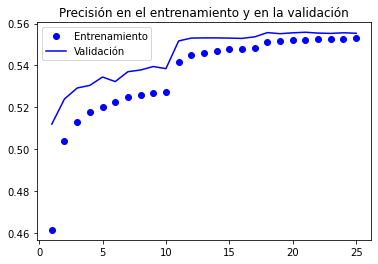

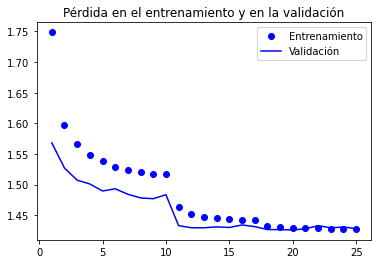

In [20]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_acc, 'b', label = 'Validación')
plt.title('Precisión en el entrenamiento y en la validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label = 'Entrenamiento')
plt.plot(epochs, val_loss, 'b', label = 'Validación')
plt.title('Pérdida en el entrenamiento y en la validación')
plt.legend()

plt.show()

Como podemos ver, la red deja de mejorar alrededor de la época 11, alcanzando una precisión en la validación de alrededor del 55%. Esto sugiere que se ha alcanzado un mínimo en la función de pérdida en este punto.

## 5. Evaluación del modelo
Ahora comprobaremos el rendimiento del modelo con datos que no ha visto antes, ***test_x*** y ***test_y***

In [21]:
results = model.evaluate(test_x, test_y)
print("Pérdida en la evaluación:", results[0])
print("Precisión en la evaluación:", results[1])

138433/138433 [==============================] - 41s 295us/step
Pérdida en la evaluación: 1.6826399037634634
Precisión en la evaluación: 0.489977091550827


Como podemos observar, la precisión en la evaluación es algo inferior a la obtenida en el entrenamiento, lo cual sugiere que hemos dado con el mínimo global de la función de pérdida para esta configuración y, además, nos deja ver que el modelo se ha sobreajustado a los datos de entrenamiento.

## 6. Generación de Haikus
A continuación generaremos haikus haciendo uso de dos métodos distintos.
### 6.1 Generación de hasta 3 líneas
Este generador escribirá caracteres hasta que se escriban tres *\n*. Se corre el riesgo de que el generador continúe hasta el infinito si no se escriben estos tres caracteres.

Puede modificarse la temperatura y la frase que servirá para empezar a generar texto. No obstante, esta frase debe ser de longitud *maxlen*

In [17]:
temperatura = 0.7
#Frase que el modelo necesita para comenzar a generar, tiene que ser de longitud maxlen
sentence = "the eagle flies and\n"

generated = ''
num_versos = 0
model.load_weights('generador_haikus1.h5')

print('----- Generando con la semilla: "' + sentence + '"')
sys.stdout.write(generated)

while num_versos < 3:
    x_pred = np.zeros((1, maxlen, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t, char_indices[char]] = 1.

    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, temperatura)
    next_char = indices_char[next_index]
    if next_char == "\n":
        num_versos += 1
    generated += next_char
    sentence = sentence[1:] + next_char

    sys.stdout.write(next_char)
    sys.stdout.flush()


----- Generando con la semilla: "the eagle flies and
"
saturday close to
the last fairages
with my dog year that was like strength


Como podemos ver, se generan palabras de la lengua inglesa correctamente, incluso parece que se han aprendido algunas estructuras sintácticas correctamente, pero el texto generado tiene poco o ningún sentido.

### 6.2 Generador de hasta 200 caracteres
El próximo generador escribirá texto hasta que hayan 200 caracteres escritos.

In [30]:
temperatura = 0.5
sentence = "the eagle flies and\n"
print('----- Generando con la semilla: "' + sentence + '"')

for i in range(200):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperatura)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()

----- Generando con la semilla: "the eagle flies and
"
i wanna get the content of the same is the book for the and one
in my fun shadows soon is the parting the best real for passion in the only stars the same is the million with the story to someone
i ne

Comprobando la salida que nos devuelve este generador, podemos ver que esta no es una buena forma de intentar generar poemas. En este caso, vemos que todas las palabras son reales, a excepción de la última, que fue cortada por el límite de caracteres. También podemos observar que se intenta mantener coherencia sintáctica entre las palabras, pero conforme se alarga la frase, el sentido de la misma empieza a desvanecerse.